# Simulating Donut Images
*David Thomas and Emily Li 2019/07/08*

**Abstract:** We learn how to simulate donuts with [batoid](https://github.com/jmeyers314/batoid). We add different detector offsets, field locations, and perturbations in the problems.

**Table of Contents:**
- [Simulating A Donut](#Simulating-A-Donut)
- [Problems](#Problems)

## Simulating A Donut

Let's start by importing the packages we will be using.

In [1]:
%matplotlib inline
import batoid
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt

Let's create a new telescope. This will make it easier to ensure that we are using the right version of the telescope object in different cells.

In [2]:
LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
config = yaml.load(open(LSST_g_fn))
telescope = batoid.parse.parse_optic(config['opticalSystem'])
telescope.itemDict['LSST.LSSTCamera.Detector']

Detector(Plane(), obscuration=ObscNegation(ObscCircle(0.4)), name='Detector', coordSys=CoordSys([0,0,4.43057],[[1,0,0],[0,1,0],[0,0,1]]), inMedium=Air(69.328, 293.15, 1.067), outMedium=Air(69.328, 293.15, 1.067))

In order to get donut images, the image plane needs to be out of focus. For LSST, the wavefront chips have two components - intra-focal and extra-focal - which are 1.5 mm in front of and behind focus respectively. Batoid does not have knowledge of the wavefront chip layout within the focal plane. Therefore we, the client, have to set up the optical system so that it is out of focus. We can do this with the method below.

In [3]:
telescope = telescope.withGloballyShiftedOptic('LSST.LSSTCamera.Detector', [0,0,1.5e-3])

This moves the plane 1.5 mm out of focus. The positive z-direction take objects behind focus (as opposed to in front of focus). Next let's make a donut image at (0,0).

In [4]:
thx, thy = 0, 0

Next we have to figure out what direction light must be travelling, which we represent with [direction cosines](https://en.wikipedia.org/wiki/Direction_cosine). Batoid has a nice helper for this.

In [5]:
xcos, ycos, zcos = batoid.utils.gnomonicToDirCos(thx, thy)

Next we create a `batoid._batoid.RayVector` with our initial rays above the telescope. The uniform distinction means that the rays will be uniformly sampled from the initial annular surface.

In [6]:
nphot = int(2e4)
wavelength = 500e-9
fluxPerPhoton = 1

distanceFromFirstSurface = telescope.dist
entrancePupilOuterRadius = telescope.pupilSize/2
entrancePupilInnerRadius = telescope.pupilSize*telescope.pupilObscuration/2

rays = batoid.uniformCircularGrid(
    distanceFromFirstSurface, 
    entrancePupilOuterRadius, 
    entrancePupilInnerRadius,
    xcos, ycos, -zcos,
    nphot, wavelength, fluxPerPhoton,
    telescope.inMedium
)

Let's see what this starting surface looks like.

In [7]:
print(len(rays))

20000


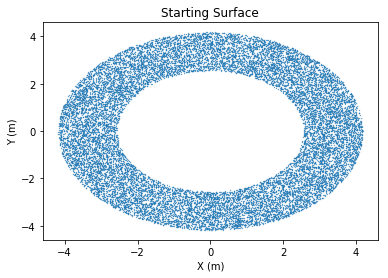

In [8]:
plt.title('Starting Surface')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.scatter(rays.x, rays.y, s=0.1);
# The semi-colon in the line above suppresses the returned value in the Jupyter notebook.
# Can you see the difference when it is removed?

For the field position 0,0 these points lie in a plane on the z-axis.

In [9]:
print(rays.z.min())
print(rays.z.max())

15.0
15.0


Now let's start raytracing, or propagating the rays we created through the optical system. 

In [10]:
telescope.traceInPlace(rays);

Let's see where they are now.

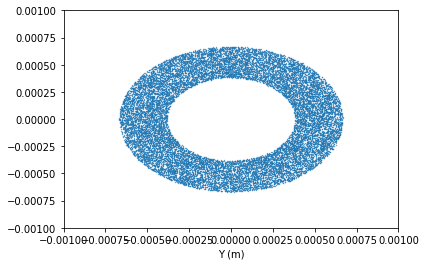

In [12]:
plt.scatter(rays.x, rays.y, s=0.1)
d = 0.001
plt.xlim([-d,d])
plt.xlabel('X (m)')
plt.ylim([-d,d])
plt.xlabel('Y (m)');

In [13]:
print(rays.z)

[ -2.43555176e-15  -5.75928194e-16  -6.93889390e-17 ...,  -1.12410081e-15
  -2.20656826e-15  -2.49800181e-16]


**Problem 1:** Do you remember where numbers like 1e-15, 1e-16 come from? Hint: machine precision.

In practice, our resolution is limited by the size of a pixel. Next we need to convert the raw list of rays into a pixelized image. We use a trick: we take a histogram of the ray positions and set the space between bin edges to be 10 microns (10e-6), the size of a LSST pixel.

In [14]:
xedges = np.arange(-.001, 0.001, 10e-6)
yedges = np.arange(-.001, 0.001, 10e-6)
result, _, _ = np.histogram2d(rays.x, rays.y, bins=[xedges, yedges])
# the _ serves as a placeholder and heads up that we will not use the value. 

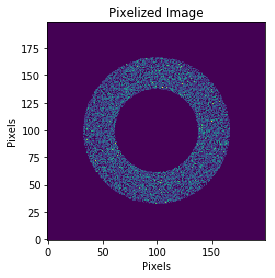

In [15]:
plt.title('Pixelized Image')
plt.imshow(result, origin='lower')
plt.xlabel('Pixels')
plt.ylabel('Pixels');

**Problem 2:** What is going here and how would you fix it? We go over solutions in the next section.

Let's collect the things we have done so far into functions.

In [16]:
def simulateDonut(telescope, nphot=int(2e4), thx=0, thy=0, wavelength=500e-9):
    flux = 1
    
    xcos, ycos, zcos = batoid.utils.gnomonicToDirCos(thx, thy)
    outRadius = telescope.pupilSize/2
    inRadius = telescope.pupilSize*telescope.pupilObscuration/2
    
    rays = batoid.uniformCircularGrid(
        telescope.dist, 
        outRadius, 
        inRadius,
        xcos, ycos, -zcos,
        nphot, wavelength, flux,
        telescope.inMedium)
    
    telescope.traceInPlace(rays)
    rays.trimVignettedInPlace()
    
    xcent, ycent = np.median(rays.x), np.median(rays.y)
    pix = 10e-6
    width = 192 * pix
    
    xedges = np.arange(xcent-width/2, xcent+width/2, pix)
    yedges = np.arange(ycent-width/2, ycent+width/2, pix)
    result, _, _ = np.histogram2d(rays.x, rays.y, bins=[xedges, yedges])
    
    return rays, result

def loadTelescope(offset=1.5e-3):
    LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
    config = yaml.load(open(LSST_g_fn))
    telescope = batoid.parse.parse_optic(config['opticalSystem'])
    telescope = telescope.withGloballyShiftedOptic('LSST.LSSTCamera.Detector', [0,0,offset])
    return telescope

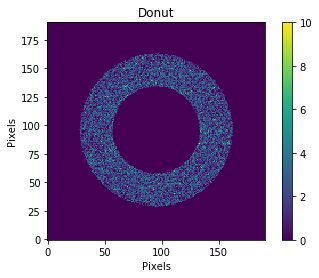

In [17]:
rays, res = simulateDonut(loadTelescope())

plt.title('Donut')
plt.imshow(res, origin='lower')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar();

The ideal stars for donut images are between 14th-17th magnitude. A 16th magnitude star, for example, produces roughly 1.1 million electrons in the LSST camera (after atmospheric and filter transmission, quantum efficiency of chips, ...). Let's time how long it takes to raytrace different numbers of photons.

In [18]:
telescope = loadTelescope()

In [19]:
%%time
nphot = int(2e4)
_, res1 = simulateDonut(telescope, nphot=nphot)

CPU times: user 91.9 ms, sys: 7.23 ms, total: 99.1 ms
Wall time: 55.5 ms


In [20]:
%%time
nphot = int(1e7)
_, res2 = simulateDonut(telescope, nphot=nphot)

CPU times: user 47.5 s, sys: 1.03 s, total: 48.5 s
Wall time: 17.6 s


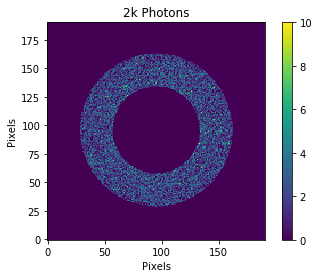

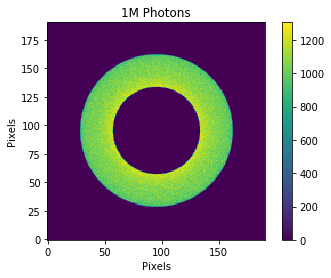

In [21]:
plt.figure()
plt.title('2k Photons')
plt.imshow(res1, origin='lower')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar()

plt.figure()
plt.title('1M Photons')
plt.imshow(res2, origin='lower')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar();

The runtime is linear with respect to the number of photons. It goes up by a factor of roughly (1e7/2e4), which is the ratio of the number of photons used. 

# Problems

**Problem 3:** What about donuts that have a -1.5 mm offset from focus, are they different? (Note: these are intra-focal, or before focus in batoid's coordinate system) Try simulating a donut with 1 million photons and an offset of -1.5 mm. Hint: use offset argument in loadTelescope.

In [22]:
# TODO: code here

**Problem 4:** Does this change if we introduce a small perturbation? Try introducing a 1 mm spatial translation to M2 and see what effect this has on each of the donuts (offset = + 1.5 mm, - 1.5 mm).

In [23]:
# TODO: code here

**Problem 5:** Now try simulating intra-focal and extra-focal donuts at the field position 1.176 deg, 1.176 deg. This is the location of one of the wavefront sensors. Hint: use thx, thy arguments in simulateDonut (should be in radian).

In [24]:
# TODO: code here

**Problem 6:** Why are the shapes different? Hint: are some rays blocked from reaching the detector? Hint: you can try running without rays.trimVignettedInPlace().

**Problem 7:** The wavefront sensors are in the corners. The center of the field is (0,0). Given that one of the sensors is at (1.176 deg, 1.176 deg), where do you think the others are?

**Challenge Problem 8:** In RaytracingAndFittingTheOPD.ipynb we learned how to add surface perturbations to the mirror surfaces that were parameterized with zernike coefficients. Try introducing a mirror perturbation and see how that changes the intra-focal and extra-focal donuts at field positions (0,0) and (1.176, 1.176).

In [25]:
# TODO: code here

**Challenge Problem 9:** Introduce a perturbation, simulate intra-focal and extra-focal donuts at (1.176, 1.176) then gradually reduce the perturbation by applying a multiplicative factor. Plot the sequence of images. This is what we hope to see when we run the AOS, that perturbations are corrected and the system approaches the nominal optical state after a few iterations.

In [ ]:
# TODO: code here